In [1]:
# %% [IMPORTS AND SETUP]
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Minimiza mensajes de advertencia de TF

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Dense, Activation, Dropout, Conv2D, 
                                     MaxPooling2D, BatchNormalization, Flatten)
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence

from pathlib import Path
from typing import Optional, List, Tuple, Dict

import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')

import datetime
from datetime import datetime
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

print ('modules loaded')


modules loaded


C:\Users\chete\AppData\Local\Temp\ipykernel_19916\791244354.py:37: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [2]:
# -------------------------------------------------
# UTILIDADES SIMPLIFICADAS
# -------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt


def preview_batch(generator, max_imgs: int = 25) -> None:
    """
    Muestra hasta `max_imgs` imágenes del siguiente batch que
    entrega un `ImageDataGenerator`.

    Parameters
    ----------
    generator : keras.utils.Sequence
        Generador que produce pares (images, labels).
    max_imgs : int, optional
        Límite de imágenes a visualizar (por defecto 25).
    """
    images, labels = next(generator)          # 1 batch
    class_names = list(generator.class_indices)   # orden Keras

    n = min(len(images), max_imgs)
    cols = 5
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(images[i] / 255.0)          # simple normalización
        label_idx = int(np.argmax(labels[i]))
        ax.set_title(class_names[label_idx], fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def show_first_image_per_class(root_dir: str) -> None:
    """
    Busca *una* imagen llamada ``1.jpg`` dentro de cada subcarpeta
    de ``root_dir`` y la muestra. Cada subcarpeta se considera
    una clase.

    Parameters
    ----------
    root_dir : str
        Carpeta con subdirectorios de clases.
    """
    subdirs = sorted(d for d in os.listdir(root_dir)
                     if os.path.isdir(os.path.join(root_dir, d)))

    cols = 5
    rows = int(np.ceil(len(subdirs) / cols))
    plt.figure(figsize=(cols * 3.5, rows * 3.5))

    for i, cls in enumerate(subdirs):
        img_path = os.path.join(root_dir, cls, "1.jpg")
        if not os.path.exists(img_path):
            continue
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(plt.imread(img_path))
        ax.set_title(cls, fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def cprint(msg: str, *, color: str = "green") -> None:
    """
    Imprime `msg` en color ANSI sencillo. Usar sólo nombres
    básicos ('red', 'green', 'yellow', 'blue', 'cyan').

    Parameters
    ----------
    msg : str
        Texto a imprimir.
    color : str, optional
        Color solicitado (por defecto 'green').
    """
    colors = {
        "red":    "31",
        "green":  "32",
        "yellow": "33",
        "blue":   "34",
        "cyan":   "36"
    }
    code = colors.get(color.lower(), "0")
    print(f"\033[{code}m{msg}\033[0m")


In [3]:
# -----------------------------------------------------------------------------
# FLEXIBLE L‑RATE ASSISTANT  (drop‑in reemplazo de la antigua clase LRA)
# -----------------------------------------------------------------------------
class FlexLRA(Callback):
    """Callback avanzado de *Learning‑Rate Adaptation* (mantiene **TODAS** las
    funciones del código original pero con una lógica más compacta).

    Funcionalidades:
    1. **Reduce** la *learning‑rate* según *patience* (Plateau LR‑Scheduler).
    2. **Early‑stop** después de *stop_patience* reducciones consecutivas sin mejora.
    3. **Restauración de pesos** del mejor epoch al terminar o al activar *dwell*.
    4. **Cambio de métrica**: empieza monitorizando *training accuracy*; cuando
       esta supera *threshold* pasa a vigilar *val_loss*.
    5. **Dwell**: si una época no mejora, recupera los pesos del mejor epoch
       antes de continuar (opcional).
    6. **ask_epoch**: en la época indicada (y sucesivas) pregunta al usuario si
       desea *H*alt, *T*une (activar *fine‑tuning*) o cuántas epochs extra correr.
    7. **CSV logging** (opcional) con las estadísticas de cada epoch.

    Parameters
    ----------
    model : tf.keras.Model
        Modelo compilado que se entrena (se pasa automáticamente al instanciar).
    base_model : tf.keras.Model | None
        Sub‑modelo que puede congelarse y luego habilitarse para *fine‑tuning*.
        Si es *None* se ignoran las opciones *T*.
    patience : int
        Épocas sin mejora antes de reducir LR.
    stop_patience : int
        Nº de reducciones permitidas sin mejora antes de detener entrenamiento.
    threshold : float
        Accuracy de entrenamiento a partir de la cual se cambia el monitor a
        *val_loss*.
    factor : float
        Multiplicador de LR (lr *= factor) cuando se reduce.
    dwell : bool
        Si *True*, tras una época sin mejora se restauran los pesos previos.
    batches : int
        Cuántos batches hay en cada epoch (solo para print de progreso).
    initial_epoch, epochs : int
        Contadores usados solo para mostrar información formateada.
    ask_epoch : int | None
        Epoch a partir de la cual se lanza la consulta interactiva (o *None*).
    csv_path : str | None
        Ruta base donde guardar el *log* CSV (se añade timestamp).
    verbose : int (0/1)
        1 imprime mensajes en consola; 0 los silencia.
    """

    def __init__(
        self,
        *,
        model: tf.keras.Model,
        base_model: Optional[tf.keras.Model],
        patience: int = 1,
        stop_patience: int = 3,
        threshold: float = 0.90,
        factor: float = 0.5,
        dwell: bool = True,
        batches: int,
        initial_epoch: int,
        epochs: int,
        ask_epoch: Optional[int] = None,
        csv_path: Optional[str] = None,
        verbose: int = 1,
    ) -> None:
        super().__init__()
        # ajustes de usuario
        self.base_model = base_model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.batches = batches
        self.init_epoch = initial_epoch
        self.total_epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_initial = ask_epoch
        self.csv_path = csv_path
        self.verbose = bool(verbose)

        # estado interno
        self._no_improve: int = 0          # epochs sin mejora
        self._lr_cuts: int = 0             # reducciones realizadas
        self._best_epoch: int = 0
        self._best_weights = model.get_weights()
        self._best_train_acc = 0.0
        self._best_val_loss = np.inf
        self._log: Dict[str, List] = {
            k: [] for k in [
                "epoch", "loss", "train_acc", "val_loss", "val_acc",
                "lr_now", "lr_next", "monitor", "%improv", "sec"
            ]
        }
        self._start: float = 0.0

    # -------------------------------------------- HOOKS --------------------------------------------
    def on_train_begin(self, logs=None):
        self._start = time.time()
        if self.verbose:
            mode = "trainable" if (self.base_model and self.base_model.trainable) else "frozen"
            print(f"FlexLRA · start ({mode}) – monitoring accuracy ➜ val_loss (threshold={self.threshold})")
            header = ("Ep  |  Loss   TrAcc   VLoss   VAcc   LR ➜ NextLR  Monitor  Δ%  Sec")
            print(header)

    def on_train_batch_end(self, batch, logs=None):
        if self.verbose:
            acc = logs.get("accuracy", 0) * 100
            loss = logs.get("loss", 0)
            print(f"\rBatch {batch+1}/{self.batches}  acc={acc:5.2f}%  loss={loss:.4f}", end="")

    def on_epoch_begin(self, epoch, logs=None):
        self._epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):  # noqa: C901 – método largo pero lineal
        # ------------------------------------------------------------------
        # RECOPILAR MÉTRICAS BÁSICAS
        t_loss: float = logs.get("loss", 0.0)
        t_acc: float = logs.get("accuracy", 0.0)
        v_loss: float = logs.get("val_loss", np.inf)
        v_acc: float = logs.get("val_accuracy", 0.0)
        lr_now: float = float(K.get_value(self.model.optimizer.lr))
        lr_next: float = lr_now  # se actualizará si reducimos
        duration = time.time() - self._epoch_start

        # ------------------------------------------------------------------
        # SELECCIÓN DEL MONITOR Y CÁLCULO DEL % DE MEJORA
        if t_acc < self.threshold:                            # fase 1 → monitor=accuracy
            monitor, current, best = "acc", t_acc, self._best_train_acc
        else:                                                 # fase 2 → monitor=val_loss (queremos minimizar)
            monitor, current, best = "val_loss", v_loss, self._best_val_loss
        if best in (0.0, np.inf):   # primera comparación
            pct_improv = 0.0
        else:
            delta = (current - best) if monitor == "acc" else (best - current)
            pct_improv = 100 * delta / (abs(best) + 1e-8)

        # ------------------------------------------------------------------
        # ¿HAY MEJORA?
        improved = (current > best) if monitor == "acc" else (current < best)
        if improved:
            # reset counters y guardar pesos
            if monitor == "acc":
                self._best_train_acc = current
            else:
                self._best_val_loss = current
            self._best_epoch = epoch + 1
            self._best_weights = self.model.get_weights()
            self._no_improve = 0
            self._lr_cuts = 0 if monitor == "acc" else self._lr_cuts  # solo reset en fase 1
        else:
            self._no_improve += 1

        # ------------------------------------------------------------------
        # REDUCE LR SI CORRESPONDE
        if self._no_improve >= self.patience:
            lr_next = max(lr_now * self.factor, 1e-7)
            K.set_value(self.model.optimizer.lr, lr_next)
            self._no_improve = 0
            self._lr_cuts += 1
            # Dwell → restaurar mejores pesos
            if self.dwell:
                self.model.set_weights(self._best_weights)

        # ------------------------------------------------------------------
        # EARLY STOP
        if self._lr_cuts >= self.stop_patience:
            if self.verbose:
                print(f"\nEarly‑stop: {self.stop_patience} recortes de LR sin mejora • Restaurando epoch {self._best_epoch}.")
            self.model.stop_training = True
            self.model.set_weights(self._best_weights)

        # ------------------------------------------------------------------
        # LOG IMPRESO (una sola línea simple)
        if self.verbose:
            print(
                f"\n{epoch+1:3d}/{self.total_epochs:3d}  "
                f"{t_loss:.4f}  {t_acc*100:6.2f}%  "
                f"{v_loss:.4f}  {v_acc*100:6.2f}%  "
                f"{lr_now:7.1e} ➜ {lr_next:7.1e}  {monitor:>8s}  "
                f"{pct_improv:+6.2f}%  {duration:4.1f}s"
            )

        # ------------------------------------------------------------------
        # GUARDAR EN LOG interno → CSV opcional
        self._log_epoch(epoch, t_loss, t_acc, v_loss, v_acc, lr_now, lr_next, monitor, pct_improv, duration)

        # ------------------------------------------------------------------
        # INTERACCIÓN ASK_EPOCH
        if self.ask_epoch and (epoch + 1) >= self.ask_epoch and not self.model.stop_training:
            self._interactive_prompt(epoch)

    # -------------------------------------------- AUX --------------------------------------------
    def _log_epoch(self, ep, tl, ta, vl, va, lr_now, lr_next, mon, pct, sec):
        self._log["epoch"].append(ep + 1)
        self._log["loss"].append(tl)
        self._log["train_acc"].append(ta)
        self._log["val_loss"].append(vl)
        self._log["val_acc"].append(va)
        self._log["lr_now"].append(lr_now)
        self._log["lr_next"].append(lr_next)
        self._log["monitor"].append(mon)
        self._log["%improv"].append(pct)
        self._log["sec"].append(sec)

        if self.csv_path:
            out_dir = Path(self.csv_path)
            out_dir.mkdir(parents=True, exist_ok=True)
            ts = datetime.now().strftime("%Y%m%d-%H%M%S")
            pd.DataFrame(self._log).to_csv(out_dir / f"log_{ts}.csv", index=False)

    def _interactive_prompt(self, epoch: int):  # 🛈 llamada sólo si ask_epoch está definido
        prompt = (
            "\n[FlexLRA] Epoch %d reached.  (H)alt | (T)une base_model | N (entero) más epochs: "
            % (epoch + 1)
        )
        ans = input(prompt).strip().lower()
        if ans == "h":
            self.model.stop_training = True
            self.model.set_weights(self._best_weights)
        elif ans == "t" and self.base_model is not None:
            self.base_model.trainable = True
            print("Fine‑tuning ACTIVADO – base_model.trainable = True")
        else:
            try:
                extra = int(ans)
                self.ask_epoch = epoch + 1 + extra
                self._no_improve = 0
                self._lr_cuts = 0
            except ValueError:
                print("Entrada ignorada. Continuando…")

In [ ]:
# --------------------------------------------------------------------
# PLOTTING · EVALUATION · MODEL SAVING  (versión depurada)
# --------------------------------------------------------------------

# ──────────────────────────────────────────────────────────────────
# 1) CURVAS DE ENTRENAMIENTO
# ──────────────────────────────────────────────────────────────────
def plot_history(history, start: int = 0) -> None:
    """
    Dibuja pérdidas y accuracies de train/val a partir de `history`
    (objeto devuelto por `model.fit`).

    Parameters
    ----------
    history : keras.callbacks.History
    start : int, optional
        Nº de epoch inicial (útil si continúas entrenamiento).
    """
    tr_acc = history.history["accuracy"]
    tr_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]

    epochs = range(start + 1, start + len(tr_acc) + 1)

    best_vl = int(np.argmin(val_loss)) + start + 1
    best_va = int(np.argmax(val_acc)) + start + 1

    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, label="train")
    plt.plot(epochs, val_loss, label="val")
    plt.scatter(best_vl, val_loss[best_vl - start - 1], color="red")
    plt.title("Loss");  plt.xlabel("epoch");  plt.ylabel("loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, label="train")
    plt.plot(epochs, val_acc, label="val")
    plt.scatter(best_va, val_acc[best_va - start - 1], color="red")
    plt.title("Accuracy");  plt.xlabel("epoch");  plt.ylabel("acc")
    plt.legend()

    plt.tight_layout(); plt.show()


# ──────────────────────────────────────────────────────────────────
# 2) EVALUACIÓN DETALLADA
# ──────────────────────────────────────────────────────────────────
def evaluate_predictions(
    generator: Sequence,
    preds: np.ndarray,
    show_errors: int = 0
) -> None:
    """
    Imprime accuracy, ejemplos de errores, matriz de confusión
    y classification report.

    Parameters
    ----------
    generator : keras.utils.Sequence
        Generador usado para obtener las etiquetas reales.
    preds : np.ndarray
        Probabilidades predichas (output de `model.predict`).
    show_errors : int, optional
        Nº de errores a listar. 0 = no mostrar.
    """
    y_true = generator.labels
    file_list = generator.filenames
    idx_to_cls = {v: k for k, v in generator.class_indices.items()}

    y_pred = np.argmax(preds, axis=1)
    probs   = preds[np.arange(len(preds)), y_pred]

    # Estadísticas
    mismatches = y_pred != y_true
    err_idx    = np.where(mismatches)[0]
    acc = 100 * (1 - len(err_idx) / len(preds))
    print(f"Accuracy: {acc:.2f}%  ({len(err_idx)} errores de {len(preds)})")

    # Listar errores
    if show_errors and err_idx.size:
        print(f"\nPrimeros {min(show_errors, len(err_idx))} errores:")
        print(f"{'file':<40}{'pred':<20}{'true':<20}{'prob':>6}")
        for i in err_idx[:show_errors]:
            print(f"{file_list[i][-40:]:<40}"
                  f"{idx_to_cls[y_pred[i]]:<20}"
                  f"{idx_to_cls[y_true[i]]:<20}"
                  f"{probs[i]:6.2f}")

    # Confusion matrix (hasta 30 clases)
    classes = list(idx_to_cls.values())
    if len(classes) <= 30:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", cbar=False)
        plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=90)
        plt.yticks(np.arange(len(classes)) + 0.5, classes, rotation=0)
        plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
        plt.show()

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))


# ──────────────────────────────────────────────────────────────────
# 3) GUARDAR MODELO + CSV DE CLASES
# ──────────────────────────────────────────────────────────────────
from pathlib import Path
from typing import Tuple, Sequence
import pandas as pd
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def save_model_and_labels(
    out_dir: str | Path,
    model: tf.keras.Model,
    name: str,
    project: str,
    accuracy: float,
    img_size: Tuple[int, int],
    scale: str,
    offset: int,
    generator: Sequence,
) -> Tuple[str, str, str, str]:
    """
    1) SavedModel dir
    2) Frozen .pb
    3) Arquitecture JSON
    4) Pesos HDF5 (.h5)
    5) class_dict.csv
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    acc_tag  = f"{accuracy:.2f}"
    model_id = f"{name}-{project}-{acc_tag}"

    # 1) SavedModel
    saved_model_dir = out_dir / model_id
    tf.saved_model.save(model, str(saved_model_dir))
    print(f"[✓] SavedModel exportado en {saved_model_dir}")

    # 2) Frozen graph .pb
    full_model = tf.function(lambda x: model(x))
    input_spec  = tf.TensorSpec(
        (None, *img_size, model.input_shape[-1]),
        model.inputs[0].dtype
    )
    concrete_fn = full_model.get_concrete_function(input_spec)
    frozen_fn   = convert_variables_to_constants_v2(concrete_fn)
    frozen_graph_def = frozen_fn.graph.as_graph_def()

    pb_path = out_dir / f"{model_id}.pb"
    tf.io.write_graph(
        frozen_graph_def,
        str(out_dir),
        f"{model_id}.pb",
        as_text=False
    )
    print(f"[✓] Frozen graph .pb guardado en {pb_path}")

    # 4) Pesos HDF5
    weights_path = out_dir / f"{model_id}.h5"
    model.save_weights(str(weights_path), save_format="h5")
    print(f"[✓] Pesos guardados en HDF5 en {weights_path}")

    # 5) CSV de clases
    cls_dict = generator.class_indices
    df = pd.DataFrame({
        "class_index": list(cls_dict.values()),
        "class_name":  list(cls_dict.keys()),
        "height":      img_size[0],
        "width":       img_size[1],
        "scale":       scale,
        "offset":      offset,
    })
    csv_path = out_dir / "class_dict.csv"
    df.to_csv(csv_path, index=False)
    print(f"[✓] CSV de clases guardado en {csv_path}")

    return (
        str(saved_model_dir),
        str(pb_path),
        str(arch_path),
        str(weights_path),
        str(csv_path),
    )


In [5]:
# --------------------------------------------------------------------
# DATA PREP  · TRIM  · BALANCE
# --------------------------------------------------------------------
from __future__ import annotations
from pathlib import Path
from typing import Tuple, List

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil


# ──────────────────────────────────────────────────────────────────
# 1) RECORTE DE MUESTRAS POR CLASE
# ──────────────────────────────────────────────────────────────────
def trim_classes(
    df: pd.DataFrame,
    *,
    column: str = "labels",
    max_per_class: int = 300,
    min_per_class: int = 10,
    seed: int = 123
) -> pd.DataFrame:
    """
    Recorta cada clase a `max_per_class` elementos y descarta
    las que tengan < `min_per_class`.

    Returns
    -------
    pd.DataFrame  (misma estructura que `df` original)
    """
    df = df.copy()
    keep_blocks: List[pd.DataFrame] = []

    for label, group in df.groupby(column):
        n = len(group)
        if n > max_per_class:
            # muestreo estratificado para no perder distribución interna
            grp, _ = train_test_split(
                group,
                train_size=max_per_class,
                random_state=seed,
                stratify=group[column],
            )
            keep_blocks.append(grp)
        elif n >= min_per_class:
            keep_blocks.append(group)
        # si n < min_per_class ⇒ se descarta la clase

    out = pd.concat(keep_blocks, ignore_index=True)
    print(f"[trim] clases finales: {out[column].nunique()}  "
          f"(recortadas/eliminadas donde fue necesario)")
    return out


# ──────────────────────────────────────────────────────────────────
# 2) BALANCEO MEDIANTE AUGMENTACIÓN
# ──────────────────────────────────────────────────────────────────
def balance_dataset(
    df: pd.DataFrame,
    *,
    column: str = "labels",
    target_per_class: int = 300,
    img_size: Tuple[int, int] = (200, 200),
    work_dir: str | Path = "./",
    seed: int = 123
) -> pd.DataFrame:
    """
    Genera imágenes augmentadas para que cada clase tenga exactamente
    `target_per_class` ejemplos. Devuelve un nuevo DataFrame con
    las rutas a las imágenes originales + las augmentadas.
    """
    df = df.copy()
    work_dir = Path(work_dir)
    aug_dir  = work_dir / "aug"
    if aug_dir.exists():
        shutil.rmtree(aug_dir)
    aug_dir.mkdir(parents=True)

    # generador de Keras para augmentar 1 imagen por iteración
    aug_gen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
    )

    added: List[dict] = []
    for label, group in df.groupby(column):
        n_current = len(group)
        if n_current >= target_per_class:
            continue

        n_to_add = target_per_class - n_current
        tgt_dir = aug_dir / label
        tgt_dir.mkdir(parents=True, exist_ok=True)

        flow = aug_gen.flow_from_dataframe(
            group,
            x_col="filepaths",
            y_col=None,
            target_size=img_size,
            batch_size=1,
            shuffle=True,
            save_to_dir=tgt_dir,
            save_prefix="aug",
            color_mode="rgb",
            class_mode=None,
            seed=seed,
        )

        for _ in range(n_to_add):
            _ = next(flow)  # genera y guarda imagen
        new_files = list(tgt_dir.glob("*.jpg"))
        added.extend({"filepaths": p.as_posix(), column: label} for p in new_files)

    print(f"[balance] imágenes augmentadas creadas: {len(added)}")
    if added:
        df_aug = pd.DataFrame(added)
        df = pd.concat([df, df_aug], ignore_index=True)

    print(f"[balance] distribución final: {df[column].value_counts().to_dict()}")
    return df


# ──────────────────────────────────────────────────────────────────
# 3) CREACIÓN DE SPLITS train / val / test
# ──────────────────────────────────────────────────────────────────
def build_splits(
    root: str | Path,
    *,
    train_split: float = 0.8,
    val_split: float = 0.1,
    seed: int = 123
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Lee carpetas `train/`, `val/`, `test/` dentro de `root` y
    construye DataFrames estratificados.

    Returns
    -------
    train_df, val_df, test_df
    """
    root = Path(root)
    subdirs = ["train", "val", "test"]
    paths, labels = [], []

    for sub in subdirs:
        for cls_dir in (root / sub).iterdir():
            if not cls_dir.is_dir():
                continue
            for img in cls_dir.iterdir():
                if img.is_file():
                    paths.append(img.as_posix())
                    labels.append(cls_dir.name)

    df = pd.DataFrame({"filepaths": paths, "labels": labels})
    train_df, tmp_df = train_test_split(
        df,
        train_size=train_split,
        stratify=df["labels"],
        random_state=seed,
        shuffle=True,
    )
    val_rel = val_split / (1 - train_split)
    val_df, test_df = train_test_split(
        tmp_df,
        train_size=val_rel,
        stratify=tmp_df["labels"],
        random_state=seed,
        shuffle=True,
    )

    n_tr, n_va, n_te = map(len, (train_df, val_df, test_df))
    print(f"[splits] train={n_tr}  val={n_va}  test={n_te}")
    return train_df, val_df, test_df


[splits] train=389  val=49  test=49
[balance] imágenes augmentadas creadas: 0
[balance] distribución final: {'1': 389}
Found 389 validated image filenames belonging to 1 classes.
Found 49 validated image filenames belonging to 1 classes.
Found 49 validated image filenames belonging to 1 classes.
FlexLRA · start (trainable) – monitoring accuracy ➜ val_loss (threshold=0.9)
Ep  |  Loss   TrAcc   VLoss   VAcc   LR ➜ NextLR  Monitor  Δ%  Sec
13/13 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000  
  1/  1  0.0000  100.00%  0.0000  100.00%  1.0e-03 ➜ 1.0e-03  val_loss   +0.00%  42.2s
13/13 [==============================] - 42s 3s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


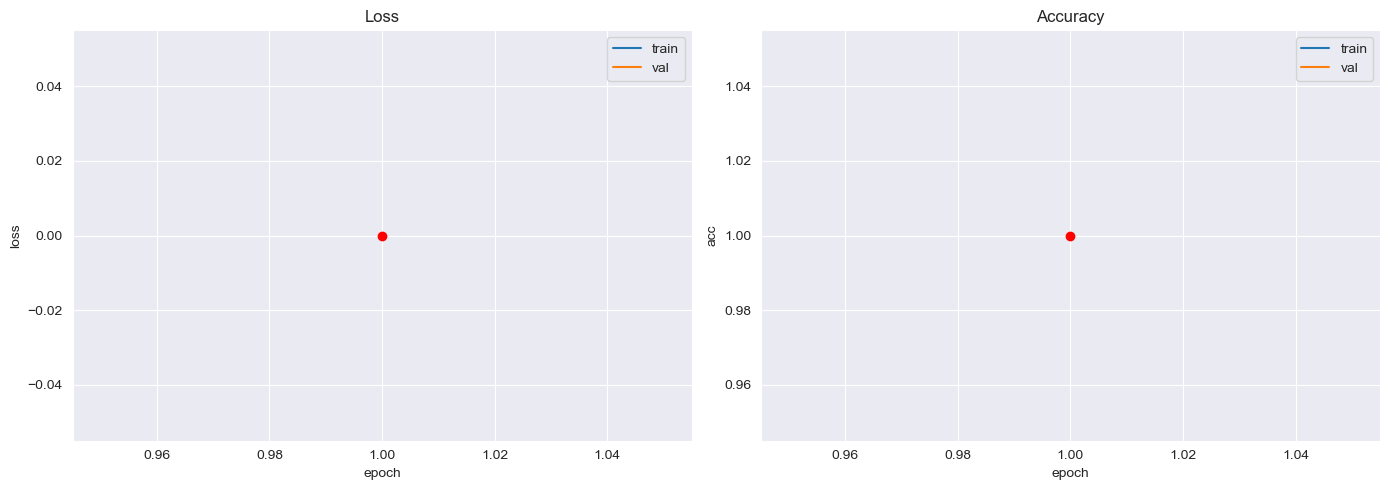

2/2 [==============================] - 2s 265ms/step
Accuracy: 100.00%  (0 errores de 49)


c:\Users\chete\Anaconda3\envs\mi_entorno\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


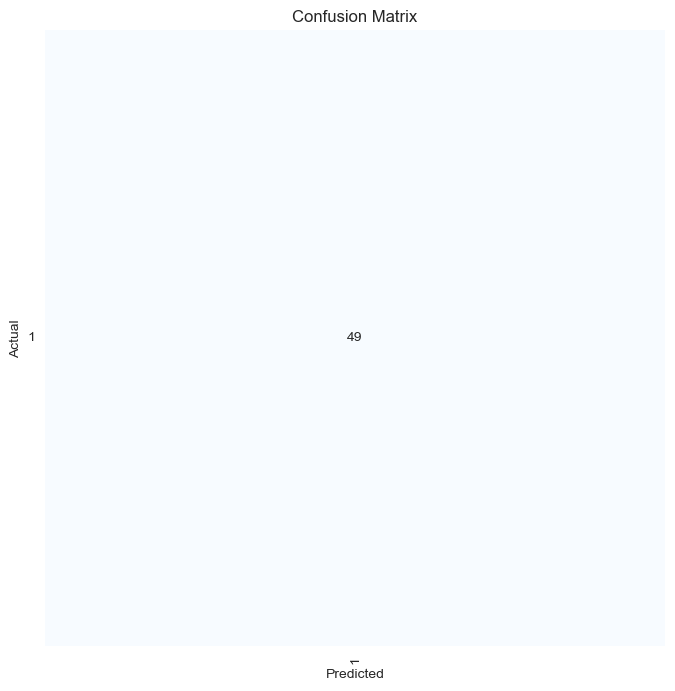


Classification report:
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        49

    accuracy                         1.0000        49
   macro avg     1.0000    1.0000    1.0000        49
weighted avg     1.0000    1.0000    1.0000        49



[✓] SavedModel exportado en C:\Users\chete\Desktop\TFG\TEEST\EffNetB0-MyClassification-100.00
[✓] Frozen graph .pb guardado en C:\Users\chete\Desktop\TFG\TEEST\EffNetB0-MyClassification-100.00.pb


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [ ]:
# ──────────────────────────────────────────────────────────────
# MAIN – entrenamiento y evaluación end‑to‑end
# ──────────────────────────────────────────────────────────────
# ---- 1. Rutas y parámetros globales ---------------------------------
base_dir      = Path(r"C:/Users/chete/Desktop/TFG/Contador Datos/30Classification")
#base_dir      = Path(r"C:\Users\chete\Desktop\TFG\TEEST")
batch_size    = 32       # normalmente 32
img_size      = (200, 200)
max_per_class = 300
min_per_class = 10
epochs        = 10          # poner 1 para pruebas rápidas
seed          = 123

# ---- 2. Splits + balanceo ------------------------------------------
train_df, val_df, test_df = build_splits(base_dir, seed=seed)
train_df = balance_dataset(
    train_df,
    target_per_class=max_per_class,
    img_size=img_size,
    work_dir=base_dir,
    seed=seed,
)

# ---- 3. Generadores de imágenes -------------------------------------
def identity(img):           # EfficientNetB0 acepta [0‑255]
    return img

def make_gen(df, shuffle: bool) -> tf.keras.utils.Sequence:
    return ImageDataGenerator(preprocessing_function=identity).flow_from_dataframe(
        df,
        x_col="filepaths",
        y_col="labels",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        color_mode="rgb",
        shuffle=shuffle,
        seed=seed,
    )

train_gen = make_gen(train_df, shuffle=True)
val_gen   = make_gen(val_df,   shuffle=True)
test_gen  = make_gen(test_df,  shuffle=False)

class_names = list(train_gen.class_indices)
n_classes   = len(class_names)
steps_per_epoch = int(np.ceil(len(train_gen.labels) / batch_size))

# ---- 4. Construcción del modelo -------------------------------------
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(*img_size, 3),
    pooling="max",
)
x = BatchNormalization()(base.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(n_classes, activation="softmax")(x)
model = Model(base.input, outputs)

model.compile(
    optimizer=Adamax(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# ---- 5. Callback de adaptación del LR --------------------------------
lr_cb = FlexLRA(
    model=model,                # tu Keras model
    base_model=base,            # el EfficientNetB0 (o None)
    patience=2,                 # epochs sin mejora antes de recortar LR
    stop_patience=3,            # recortes sin mejora antes de parar
    threshold=0.9,              # pasar a vigilar val_loss
    factor=0.5,                 # lr *= factor
    dwell=True,                 # restaurar pesos si no mejora
    batches=steps_per_epoch,    # nº de batches por epoch
    initial_epoch=0,            # epoch de inicio (para mostrar)
    epochs=epochs,              # total epochs planificadas
    ask_epoch=None,             # o un entero para consulta interactiva
    csv_path=None,              # o ruta para CSV de log
    verbose=1,                  # 1 muestra mensajes, 0 silencio
)

# ---- 6. Entrenamiento ------------------------------------------------
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[lr_cb],
    verbose=1,
)

# ---- 7. Gráficas y métricas -----------------------------------------
plot_history(history)
test_gen.reset()
preds = model.predict(test_gen, verbose=1)
evaluate_predictions(test_gen, preds, show_errors=5)

# ---- 8. Guardado opcional -------------------------------------------
test_acc = model.evaluate(test_gen, verbose=0)[1] * 100
saved_model_dir, pb_path, weights_path, csv_path = save_model_and_labels(
    out_dir    = base_dir,
    model      = model,
    name       = "EffNetB0",
    project    = "MyClassification",
    accuracy   = test_acc,
    img_size   = img_size,
    scale      = "1-0",
    offset     = 0,
    generator  = train_gen,
)

print("✔ Proceso finalizado.")
print(f"  • SavedModel dir : {saved_model_dir}")
print(f"  • Frozen .pb     : {pb_path}")
print(f"  • Pesos .h5      : {weights_path}")
print(f"  • CSV de clases  : {csv_path}")
# --------------------------------------------------------------------
